In [1]:
import glob,os
from matplotlib import pyplot as plt
%matplotlib inline
import math
import random
random.seed(10)
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import os
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import ridge_regression
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from sklearn import metrics


In [19]:
def minmax(data):
    return MinMaxScaler().fit_transform(data)

def std(data):
  return StandardScaler().fit_transform(data)

def pca_output(data_):
    pca = PCA(n_components=data_.shape[1])
    pca.fit(data_)
    variance = pca.explained_variance_
    ratio = pca.explained_variance_ratio_
    components = pca.components_
    newdata = pca.fit_transform(data_)
    return variance, ratio, components, newdata

def spca_output(data, n, sparsity):
    data_ = std(data)
    spca = SparsePCA(n_components=n, random_state = 0, max_iter = 10000, alpha = sparsity)
    spca.fit(data_)
    components = spca.components_.T

    newdata = spca.fit_transform(data_)
    nuz = ridge_regression(spca.components_.T, data_.T, 0.01, solver='cholesky').T
    q,r = np.linalg.qr(nuz.T)
    cumulative_var = []
    for i in range(1,n+1):
        cumulative_var.append(np.trace(r[0:i,]*r[0:i,]))
    explained_var = [math.sqrt(cumulative_var[0])]
    for i in range(1,n):
        explained_var.append(math.sqrt(cumulative_var[i])-math.sqrt(cumulative_var[i-1]))
        
    order = np.argsort(explained_var)[::-1]
    components = np.take(components,order,axis=0)
    evars = np.take(explained_var,order).tolist()
    evars_ratio = evars/np.sum(evars)
    
    print("Explained variance in each PC \n")
    print(str(evars)+"\n")
    print("Explained variance ratios for all PCs\n")
    print(str(evars_ratio) + "\n")
    
    return evars, evars_ratio, components, newdata

def tSNE_output(data, metric_, P, init):
    normalized_data=std(data)
    tSNE = TSNE(n_components=2, perplexity=P, random_state=0, metric = metric_, init = init)
    tSNE.fit(normalized_data)
    newdata = tSNE.fit_transform(normalized_data)
    return newdata

def UMAP_output(data, n_neighbors=50, min_dist=0.05, metric='euclidean', init='random'): 
  normalized_data=std(data)
  umap_ = umap.UMAP(n_neighbors = n_neighbors,
                    min_dist = min_dist,metric = metric,init = init)
  umapNewData = umap_.fit_transform(normalized_data)
  return umapNewData

def bar_plot_E_var_ratio(ratio):
    PC_index=['PC'+str(i+1) for i in range(len(ratio))]

    plt.figure(figsize=(10,6))
    x_tick = np.arange(len(PC_index))
    for i in range(len(ratio)):
        bars = plt.bar(x_tick[i],ratio[i],width=0.3)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)),
                 ha="center", va="bottom")
    plt.xticks(x_tick,PC_index)
    plt.xlabel('Expained variance ratio')
    plt.show()
    
def PC_df(PCs, col_name):
    PCs_df = pd.DataFrame(data = PCs, index = col_name,
        columns = ['PC'+str(i+1) for i in range(PCs.shape[1])])
    print(PCs_df)
    return PCs_df

def barplot_(data_label, data, ylabel): 
    fig=plt.figure(figsize=(10,6))
    x_tick = np.arange(len(data_label))
    plt.xticks(x_tick, data_label)
    plt.ylabel(ylabel, FontSize = 12)
    
    ax = plt.gca()
    for i in range(len(x_tick)):
        bars = plt.bar(x_tick[i],data[i],width=0.8)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height,3)),
                 ha="center", va="bottom")
    for xtk_label in ax.get_xticklabels():
        xtk_label.set_rotation(45)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    plt.show()
    
def feature_importance(df, var, n):
    df_dim = df.iloc[:, 0:n]
    weight = var[0:2]
    df_dim['feature importance'] = (df_dim**2).apply(lambda x: np.sqrt(x.dot(weight)), axis = 1)
    sorted_feature_importance_df = df_dim['feature importance'].sort_values(ascending = False)
    bar_data_label = sorted_feature_importance_df.index.values
    bar_data = sorted_feature_importance_df.tolist()
    ylabel = 'Feature importance score'
    barplot_(bar_data_label, bar_data, ylabel)

    return df_dim

def parallel_plot(data_df, label, color):
    from pandas.plotting import parallel_coordinates
    plt.figure(figsize = (20, 10))
    parallel_coordinates(data_df, label, color=color)
    plt.show()

In [46]:
Colors = ['blue','red','pink','green','yellow','black','orange','purple','gray',
          'cyan','brown','olive','darkred','lightsalmon','goldenrod','gold']
# Biplot,
def category_count_label(category):
    counts = category.value_counts()
    labels = counts.index
    logical_label = {}
    for i in range(len(counts.values)):
        logical_label[i]=category==counts.index[i]
    return counts, labels, logical_label
def which_category_counts(i, category_counts, category_logical_labels):
    for k in range(len(category_counts.values)):
        if category_logical_labels[k][i]==True:
            return k
def biplot(PC_new_data_, PCs_df_, index, category_counts, category_labels, category_logical_labels, scale):
    fig=plt.figure(figsize=(20,10))
    plt.style.use('ggplot')
    PC_new_data_df_ = pd.DataFrame(PC_new_data_)

    for j in range(len(category_counts.values)):
        plt.scatter(PC_new_data_[category_logical_labels[j], 0], PC_new_data_[category_logical_labels[j], 1], 
                    label = category_labels[j],
                    marker = '.',
                    color = Colors[j],
                    edgecolors = 'white', alpha = 0.95, s=90)

    for i in range(len(PC_new_data_)):
        plt.text(PC_new_data_[i,0],PC_new_data_[i,1],index[i],
                 color=Colors[which_category_counts(i, category_counts, category_logical_labels)],fontsize=15,alpha=0.55)
    #Draw variables
    scale=scale
    for k in range(PCs_df_.shape[1]):
        plt.text(PCs_df_.iloc[k,0]*scale + 0.05,PCs_df_.iloc[k,1]*scale + 0.05,
                 PCs_df_.index[k],c='black',
                 fontweight='bold',fontsize=12)
        plt.arrow(0,0,PCs_df_.iloc[k,0]*scale,PCs_df_.iloc[k,1]*scale,color='red',head_width=0.1*scale,linewidth=0.5,alpha=0.9)

    plt.xlabel('$PC_{1}$')
    plt.ylabel('$PC_{2}$')
    plt.legend()
    plt.show()

# Triplot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import HTML
import matplotlib.animation as animation

def PCA3D(newdata,fig_title, label, label_name):
    fig = plt.figure(figsize = (10,7))
    ax = Axes3D(fig)
    ax.set_title('PCA 3D plot for '+ fig_title, color = 'magenta')
    
    ax.set_xlabel('$PC_{1}$')
    ax.set_ylabel('$PC_{2}$')
    ax.set_zlabel('$PC_{3}$')
    
    mk_list = ['o','p','h','s','>','1','2','3','4','8','*']
    c_list = ['blue','red','pink','green','yellow','black','orange','purple','gray','cyan','brown']
    cmap = plt.get_cmap('tab20')
    
    for i in range(len(label)):
        ax.scatter(newdata[label[i], 0], newdata[label[i], 1], newdata[label[i], 2],
                  label = label_name[i], marker = mk_list[i], color = c_list[i], edgecolor = 'gold', alpha = 0.7, s=80)
    ax.legend()
    def init():
        plt.close(fig)
        return fig,
    def animate(i):
        ax.view_init(elev=30., azim=3.6*i)
    ani = animation.FuncAnimation(fig, animate,frames = 100)
    f = fig_title + '.mov'
    writervideo = animation.FFMpegWriter(fps=5)
    ani.save(f, writer=writervideo)

    return ani
    
def UMAP3D(newdata,fig_title, label, label_name):
    fig = plt.figure(figsize = (10,7))
    ax = Axes3D(fig)
    ax.set_title('PCA 3D plot for '+ fig_title, color = 'magenta')
    
    ax.set_xlabel('$UMAP_{1}$')
    ax.set_ylabel('$UMAP_{2}$')
    ax.set_zlabel('$UMAP_{3}$')
    
    mk_list = ['o','p','h','s','>','1','2','3','4','8','*']
    c_list = ['blue','red','pink','green','yellow','black','orange','purple','gray','cyan','brown']
    cmap = plt.get_cmap('tab20')
    
    for i in range(len(label)):
        ax.scatter(newdata[label[i], 0], newdata[label[i], 1], newdata[label[i], 2],
                  label = label_name[i], marker = mk_list[i], color = c_list[i], edgecolor = 'gold', alpha = 0.7, s=80)
    ax.legend()
    def init():
        plt.close(fig)
        return fig,
    def animate(i):
        ax.view_init(elev=30., azim=3.6*i)
    ani = animation.FuncAnimation(fig, animate,frames = 100)
    f = '/content/drive/My Drive/CSI 5V93 12 - Advanced Topics in Data Scienc/project1_/results' + fig_title + '.mov'
    writervideo = animation.FFMpegWriter(fps=5)
    ani.save(f, writer=writervideo)

    return ani
    
def tSNEplot(PC_new_data_, index, category_counts, category_labels, category_logical_labels):
    fig=plt.figure(figsize=(20,10))
    plt.style.use('ggplot')
    PC_new_data_df_ = pd.DataFrame(PC_new_data_)

    for j in range(len(category_counts.values)):
        plt.scatter(PC_new_data_[category_logical_labels[j], 0], PC_new_data_[category_logical_labels[j], 1], 
                    label = category_labels[j],
                    marker = '.',
                    color = Colors[j],
                    edgecolors = 'white', alpha = 0.95, s=90)

    for i in range(len(PC_new_data_)):
        plt.text(PC_new_data_[i,0],PC_new_data_[i,1],index[i],
                 color=Colors[which_category_counts(i, category_counts, category_logical_labels)],fontsize=15,alpha=0.95)

    plt.xlabel('$tSNE_{1}$')
    plt.ylabel('$tSNE_{2}$')
    plt.legend()
    plt.show()

def UMAPplot(PC_new_data_, index, category_counts, category_labels, category_logical_labels):
    fig=plt.figure(figsize=(20,10))
    plt.style.use('ggplot')
    PC_new_data_df_ = pd.DataFrame(PC_new_data_)

    for j in range(len(category_counts.values)):
        plt.scatter(PC_new_data_[category_logical_labels[j], 0], PC_new_data_[category_logical_labels[j], 1], 
                    label = category_labels[j],
                    marker = '.',
                    color = Colors[j],
                    edgecolors = 'white', alpha = 0.95, s=90)

    for i in range(len(PC_new_data_)):
        plt.text(PC_new_data_[i,0],PC_new_data_[i,1],index[i],
                 color=Colors[which_category_counts(i, category_counts, category_logical_labels)],fontsize=15,alpha=0.95)

    plt.xlabel('$UMAP_{1}$')
    plt.ylabel('$UMAP_{2}$')
    plt.legend()
    plt.show()

In [9]:
wine_filename = 'WineQT.csv'
wine = pd.read_csv(wine_filename)
wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9.8        5   2  
3      9.8        6   3  
4      9.4        5   4

In [10]:
wine = wine.drop(['Id'],axis = 1)
wine.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             21.000000     0.995570   
50%       0.079000            13.000000             37.000000     0.996680   
75%       0.090000            21.000000             61.000000     0.997845   
max       0.611000            68.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1143.000000  1143.000000  1143.000000  1143.000000  
mean      3.311015     0.657708    10.442111     5.657043  
std       0.156664     0.170399     1.082196     0.805824  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.205000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

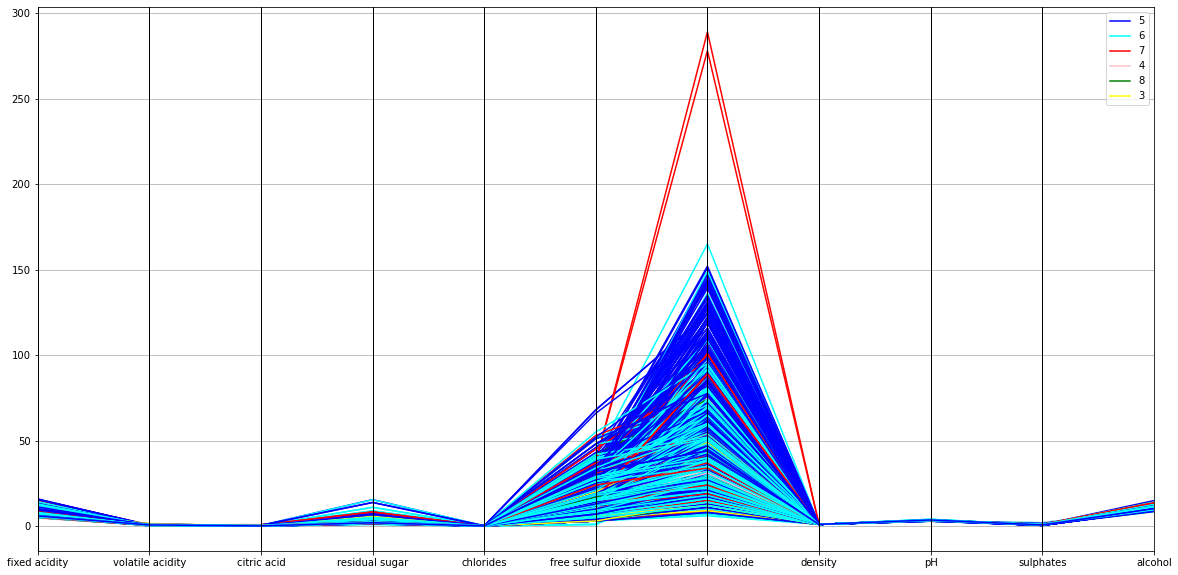

In [14]:
parallel_plot(wine, 'quality', color = ('blue','cyan','red','pink','green','yellow'))

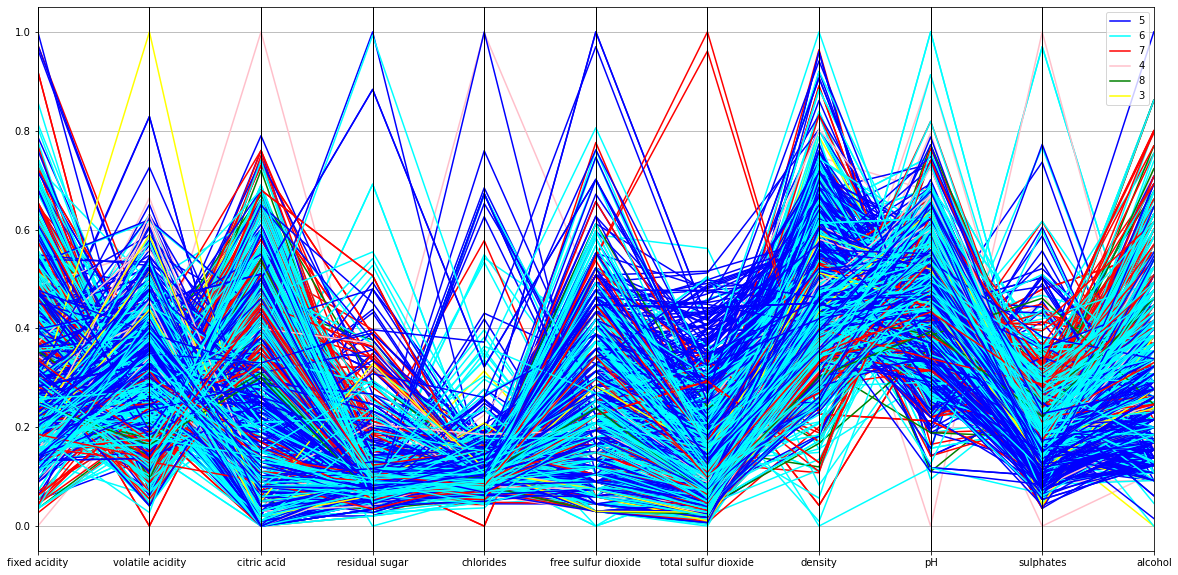

In [13]:
wine_X = wine.iloc[:,:-1]
wine_mm = minmax(wine_X)
col_name_wine = wine_X.columns.values.tolist()
wine_mm_df = pd.DataFrame(wine_mm, columns = col_name_wine)
wine_mm_df['quality'] = wine['quality']
parallel_plot(wine_mm_df, 'quality', color = ('blue','cyan','red','pink','green','yellow'))

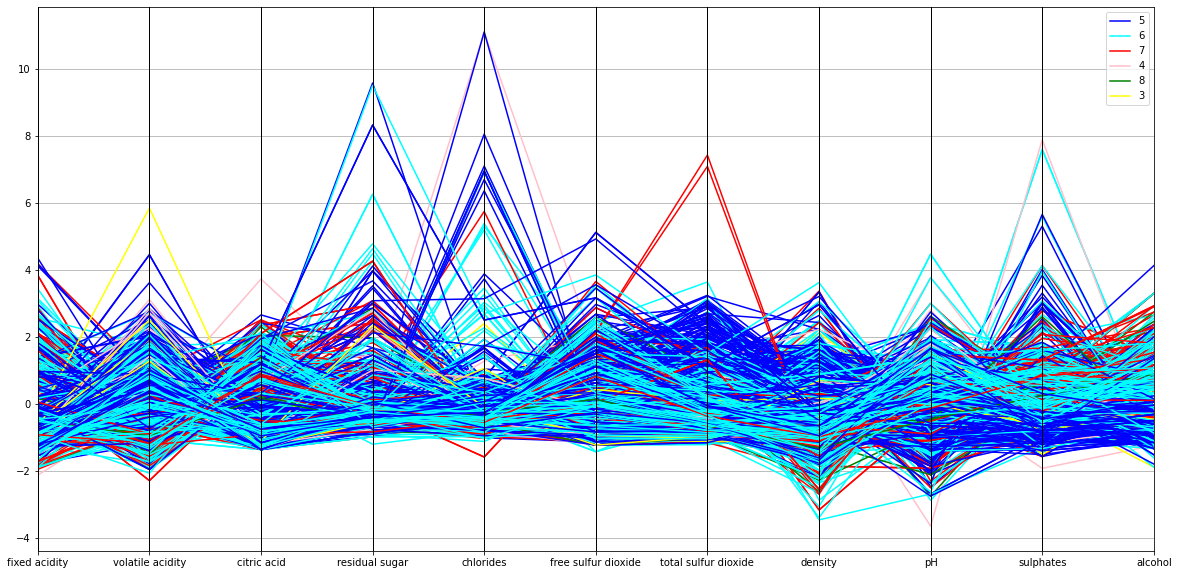

In [17]:
wine_X = wine.iloc[:,:-1]
wine_std = std(wine_X)
col_name_wine = wine_X.columns.values.tolist()
wine_std_df = pd.DataFrame(wine_std, columns = col_name_wine)
wine_std_df['quality'] = wine['quality']
parallel_plot(wine_std_df, 'quality', color = ('blue','cyan','red','pink','green','yellow'))

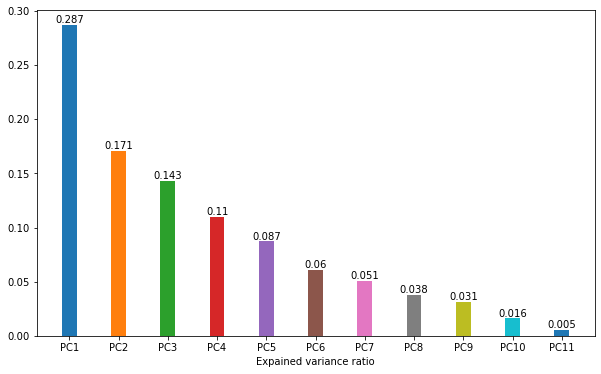

                           PC1       PC2       PC3       PC4       PC5  \
fixed acidity         0.485339 -0.227143  0.460075  0.174506  0.224870   
volatile acidity     -0.102328  0.288786 -0.146508  0.252262  0.153133   
citric acid          -0.122376 -0.443718  0.246843  0.091359 -0.052562   
residual sugar       -0.236046  0.077288 -0.063818 -0.407263  0.652669   
chlorides            -0.097378  0.257558 -0.077674  0.701141  0.270649   
free sulfur dioxide   0.103369  0.416091  0.089361  0.024817  0.318936   
total sulfur dioxide  0.345847  0.528722 -0.094853 -0.306696 -0.376973   
density              -0.188148 -0.083628 -0.378179  0.318784 -0.327715   
pH                   -0.173481  0.102909  0.346960 -0.008392 -0.084115   
sulphates             0.286999 -0.354171 -0.642313 -0.100559  0.252023   
alcohol               0.629000  0.010672 -0.053666  0.183354  0.046645   

                           PC6       PC7       PC8       PC9      PC10  \
fixed acidity        -0.047852  0.015

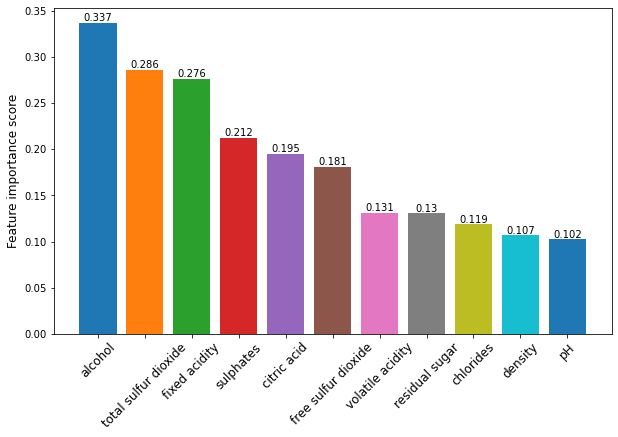

In [23]:
E_var_wine, E_var_ratio_wine, PCs_wine, PC_new_data_wine = pca_output(wine_std_df.iloc[:,:-1])
bar_plot_E_var_ratio(E_var_ratio_wine)
PCs_df_wine = PC_df(PCs_wine, col_name_wine)
PCs_df_wine.to_csv('PCs_df_wine.csv', index=False)
PC_new_data_wine_df = pd.DataFrame(data = PC_new_data_wine, columns = ['PC'+str(i+1) for i in range(PC_new_data_wine.shape[1])])
PC_new_data_wine_df.to_csv('PC_new_data_wine.csv', index=False)
PCs_df_dim_wine = feature_importance(PCs_df_wine, E_var_ratio_wine, 2)

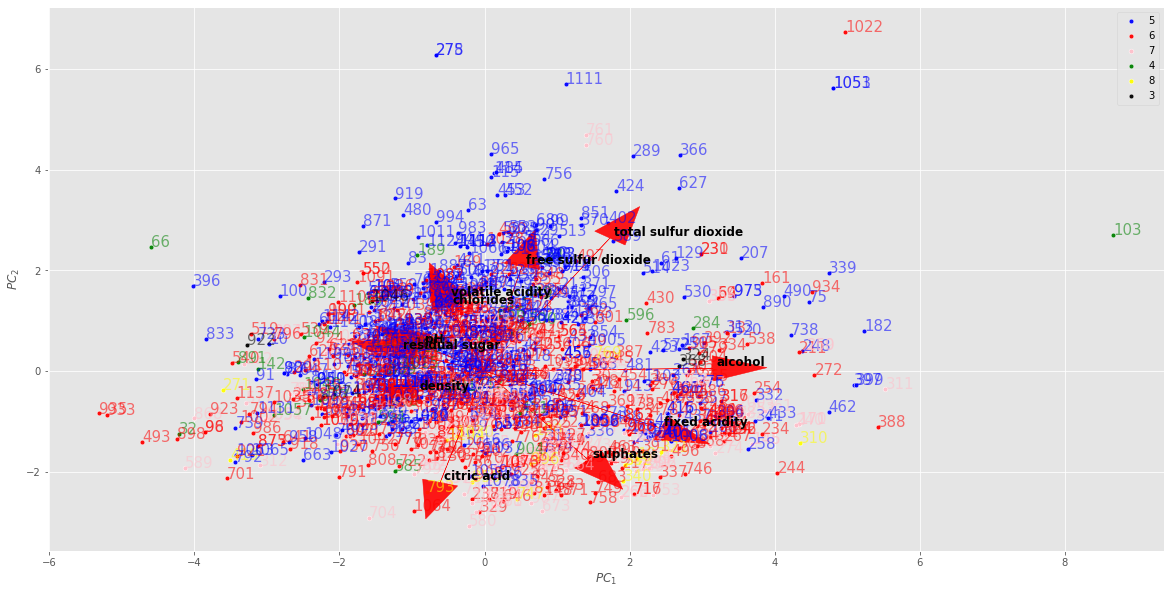

In [26]:
marker_counts_wine, marker_labels_wine, marker_logical_label_wine = category_count_label(wine['quality'])
biplot(PC_new_data_wine, PCs_df_wine, wine.index, marker_counts_wine, marker_labels_wine, marker_logical_label_wine, 5)


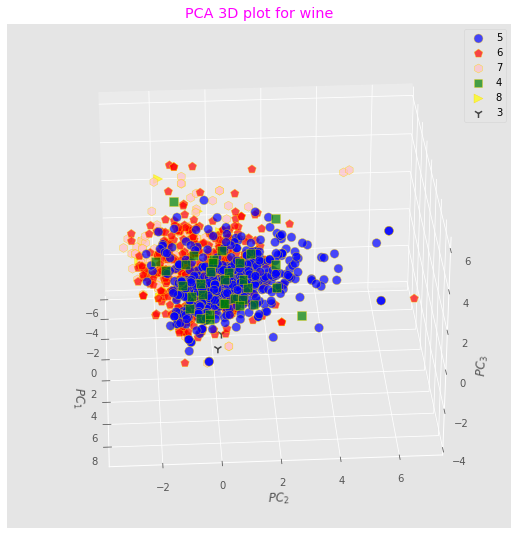

In [29]:
HTML(PCA3D(PC_new_data_wine,'wine', marker_logical_label_wine, marker_labels_wine).to_html5_video())

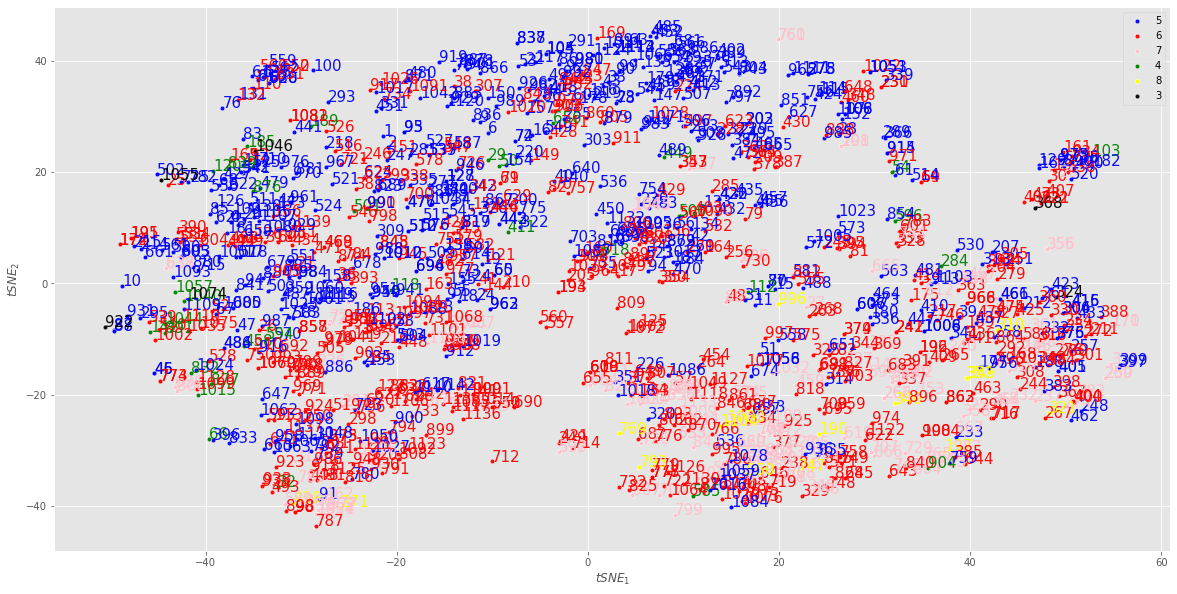

In [31]:
tSNE_new_data_wine = tSNE_output(wine_std_df.iloc[:,:-1], 'euclidean', 30, 'pca')
newdata_df = pd.DataFrame(data = tSNE_new_data_wine, columns = ['tSNE'+str(i+1) for i in range(tSNE_new_data_wine.shape[1])])
newdata_df.to_csv('tSNE_newdata.csv', index=False)
tSNEplot(tSNE_new_data_wine, wine_std_df.index, marker_counts_wine, marker_labels_wine, marker_logical_label_wine)

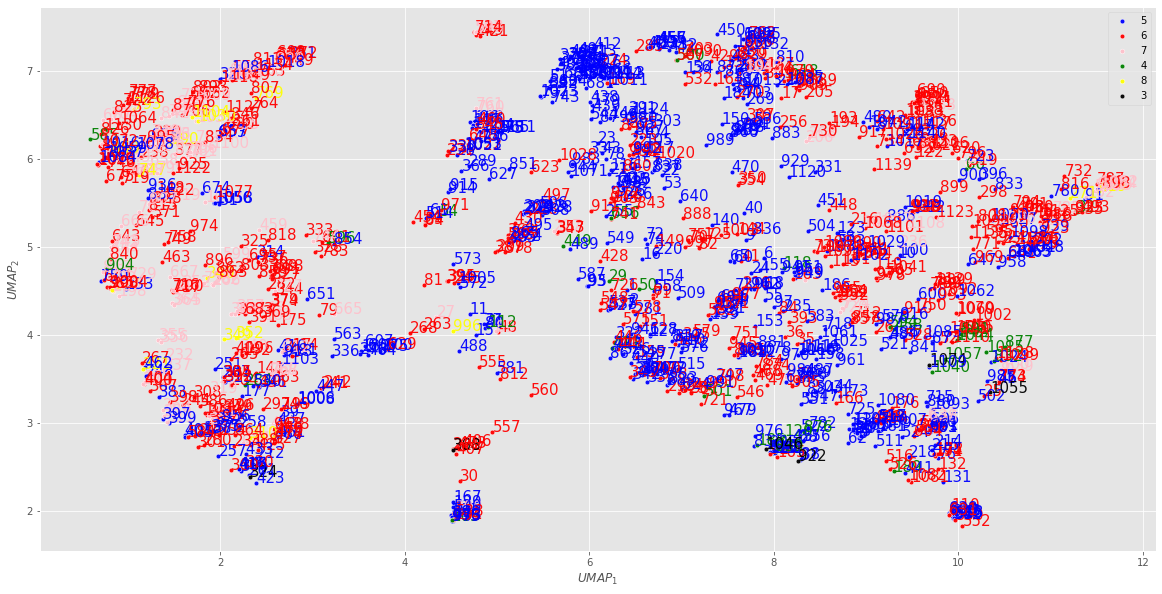

In [32]:
UMAP_new_data_wine = UMAP_output(wine_std_df.iloc[:,:-1], n_neighbors=20, min_dist=0.05, metric='euclidean', init='random')
UMAPplot(UMAP_new_data_wine, wine_std_df.index, marker_counts_wine, marker_labels_wine, marker_logical_label_wine)

In [33]:
def doDBSCAN(X, labels_true, eps = 0.25, min_samples = 10):
  db = DBSCAN(eps = eps, min_samples=min_samples).fit(X)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
  n_noise_ = list(labels).count(-1)
  print('Estimated number of clusters: %d' % n_clusters_) 
  print('Estimated number of noise points: %d' % n_noise_)
  print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels)) 
  print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels)) 
  print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
  print("Adjusted Rand Index: %0.3f"
  % metrics.adjusted_rand_score(labels_true, labels))
  print("Adjusted Mutual Information: %0.3f"
  % metrics.adjusted_mutual_info_score(labels_true, labels))
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
  # Plot result
  unique_labels = set(labels) 
  print(unique_labels)
  fig=plt.figure(figsize=(10,7)) 
  print(unique_labels)
  for k in unique_labels: 
    class_member_mask = (labels == k)
    # all core samples
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'd', markerfacecolor=Colors[k],markeredgecolor='w', markersize=10, label='core points', alpha = 0.5)
    xy2 = X[class_member_mask & ~core_samples_mask]
    if k==-1: # outlier
      plt.plot(xy2[:, 0], xy2[:, 1], 's', markerfacecolor='lightblue',
              markeredgecolor='b', markersize=8, label='outliers', alpha = 0.5)
    else:
      plt.plot(xy2[:, 0], xy2[:, 1], 'o', markerfacecolor=Colors[k], 
              markeredgecolor='w', markersize=10, label='reachable points')
    # non-core samples
    plt.legend()
  plt.title('DBSCAN clusters: %d' % n_clusters_)
  plt.grid(True, color='r', linestyle=':', linewidth=0.5) 
  plt.show() 
  return labels, n_clusters_, n_noise_

Estimated number of clusters: 1
Estimated number of noise points: 15
Homogeneity: 0.003
Completeness: 0.044
V-measure: 0.005
Adjusted Rand Index: 0.001
Adjusted Mutual Information: 0.002
Silhouette Coefficient: 0.562
{0, -1}
{0, -1}


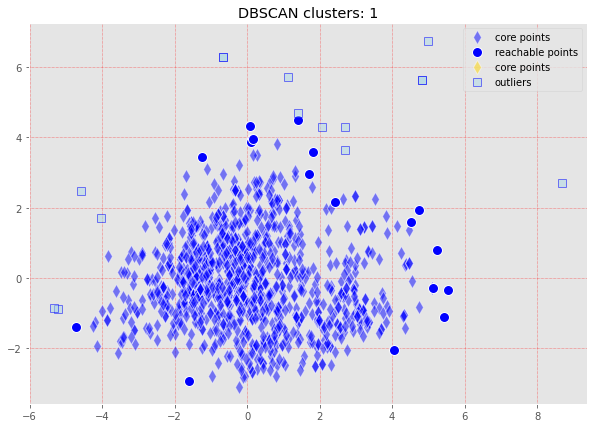

(array([0, 0, 0, ..., 0, 0, 0]), 1, 15)

In [51]:
doDBSCAN(PC_new_data_wine[:,:2], wine['quality'],1,10)